In [1]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/home/ms/hf_cache/'

import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM
from datasets import load_dataset
import seaborn as sns
import numpy

from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel
)
from peft.tuners.lora import LoraLayer
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import argparse
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/miniconda3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /root/miniconda3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/root/miniconda3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /root/miniconda3 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/root/miniconda3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/root/miniconda3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/root/miniconda3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('["/tmp/vscode-ssh-auth-3b275

In [238]:
size="7b"
# size="6.7b"
opt_name = f"facebook/opt-{size}"
opt_name = f"huggyllama/llama-{size}"
# opt_name = f"meta-llama/Llama-2-{size}-hf"
model_opt = AutoModelForCausalLM.from_pretrained(opt_name, cache_dir="/home/ms/hf_cache/hub")
opt_tokenizer = AutoTokenizer.from_pretrained(opt_name, use_fast=False, cache_dir="/home/ms/hf_cache")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [239]:
def calib_dataset(dataset, block_size, tokenizer, n_samples=20):

    text_name = dataset.column_names[0]
    dataset = dataset.shuffle(seed=52)
    
    len_sum = 0
    samples = []
    n_run = 0
    for data in dataset:
        line = data[text_name]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
#         if len(line_encoded) > 512:
#             continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break
    cat_samples= torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    output = [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]
    return output

# Scatter Plot

In [263]:
seq_len = 128
idx = 10

dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
opt_wiki_input_ids = calib_dataset(dataset, seq_len, opt_tokenizer, 200)[idx]

 * Split into 116 blocks


In [5]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
sm_func = torch.nn.Softmax(dim=-1)
ce_func = CrossEntropyLoss()
ce_none_func = CrossEntropyLoss(reduction="none")

In [151]:
outputs_128 = outputs

In [159]:
def stat_analysis(outputs):
    logits = outputs["logits"]
    # logits = quant_output["logits"]
    
    
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = opt_wiki_input_ids[..., 1:].contiguous()
    
    probs = torch.nn.Softmax(dim=-1)(outputs["logits"])
    conf_score = probs.max(-1)[0][0,:-1].cpu().detach().numpy()
    loss_all = ce_none_func(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)).cpu().detach().numpy()
    entropy = (-probs * torch.log(probs)).sum(-1)[0,:-1].cpu().detach().numpy()
    return loss_all, conf_score, entropy

In [153]:
outputs = model_opt(opt_wiki_input_ids, output_attentions="true")
loss_all, conf_score, entropy = stat_analysis(outputs)
# loss_all_128, conf_score_128, entropy_128 = stat_analysis(outputs_128)

/tmp/ipykernel_1310057/174991367.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.001, 2), 0.3, 12, color='dodgerblue', alpha=alpha, edgecolor='none', linewidth=0)
/tmp/ipykernel_1310057/174991367.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.2, 0), 0.8, 3, color='orange', alpha=alpha, edgecolor='none', linewidth=0)
/tmp/ipykernel_1310057/174991367.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0, 0), 3, 3, color='orange', alpha=alpha, edgecolor='none', linewidth=0)
/tmp/ipykernel_1310057/174991367.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((2, 3), 6, 8, color='dodgerblue', alpha=alpha, edgecolor='none', linewidth=0)


(-0.35, 13.0)

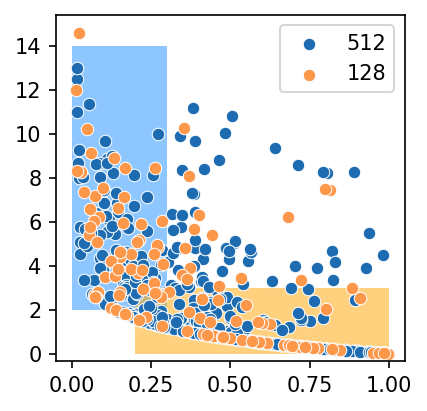

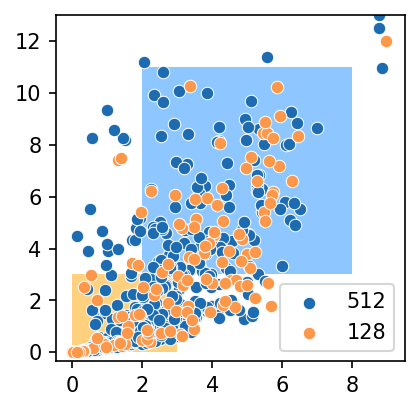

In [180]:
palette_1 = sns.color_palette("Blues", 12)
palette_2 = sns.color_palette("Oranges", 12)
color = palette_1[9]
color_2 = palette_2[5]
alpha=0.5
alpha_2=1

fig, axes = plt.subplots(1, 1, figsize=(3,3), dpi=150)

from matplotlib.patches import Rectangle
rect = Rectangle((0.001, 2), 0.3, 12, color='dodgerblue', alpha=alpha, edgecolor='none', linewidth=0)
axes.add_patch(rect)
rect = Rectangle((0.2, 0), 0.8, 3, color='orange', alpha=alpha, edgecolor='none', linewidth=0)
axes.add_patch(rect)
sns.scatterplot(y=loss_all, x=conf_score, ax=axes, color=color, label="512", alpha=alpha_2)
# sns.scatterplot(y=loss_all_128, x=conf_score_128, ax=axes, color=color_2, label="128", alpha=alpha_2)

plt.ylim(-0.35,15.4)

fig, axes = plt.subplots(1, 1, figsize=(3,3), dpi=150)

from matplotlib.patches import Rectangle
rect = Rectangle((0, 0), 3, 3, color='orange', alpha=alpha, edgecolor='none', linewidth=0)
axes.add_patch(rect)
rect = Rectangle((2, 3), 6, 8, color='dodgerblue', alpha=alpha, edgecolor='none', linewidth=0)
axes.add_patch(rect)
sns.scatterplot(y=loss_all, x=entropy, ax=axes, color=color, label="512", alpha=alpha_2)
# sns.scatterplot(y=loss_all_128, x=entropy_128, ax=axes, color=color_2, label="128", alpha=alpha_2)

plt.ylim(-0.35,13)

# Cumulative Quantization Error

In [243]:
def w_quantize_func(w): 

    # TWN Quantization
    org_w_shape = w.shape
    q_group_size = -1
    
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)
    else:
        w = w.reshape(-1, w.shape[-1])

    n = w[0].nelement()
    m = w.data.norm(p=1, dim=1).div(n)
    thres = (0.7 * m).view(-1, 1).expand_as(w)
    pos = (w > thres).float()
    neg = (w < -thres).float()
    mask = (w.abs() > thres).float()
    alpha = ((mask * w).abs().sum(dim=1) / mask.sum(dim=1)).view(-1, 1)
    w = alpha * pos - alpha * neg
    
    assert torch.isnan(w).sum() == 0

    w_q = w.reshape(org_w_shape)

    return w_q.detach()    

def get_named_linears(module): 
    return {name: m for name, m in module.named_modules() if isinstance(m, torch.nn.Linear)}

In [244]:
# Apply Quantization
model = model_opt
quant_model = copy.deepcopy(model_opt).cpu()

layers = quant_model.model.layers

for i in tqdm(range(len(layers)), desc="pseudo weight quantization..."):
    named_linears = get_named_linears(layers[i])
    for n, m in named_linears.items():
        m.cuda()
        m.weight.data = w_quantize_func(m.weight.data)
        m.cpu()

pseudo weight quantization...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.40it/s]


In [264]:
# Quantize Model Inference
quant_output = quant_model(opt_wiki_input_ids, output_attentions="true")
outputs = model_opt(opt_wiki_input_ids, output_attentions="true")

fp_attn = outputs["attentions"]
q_attn = quant_output["attentions"]

In [197]:
mask.shape

torch.Size([32, 128, 128])

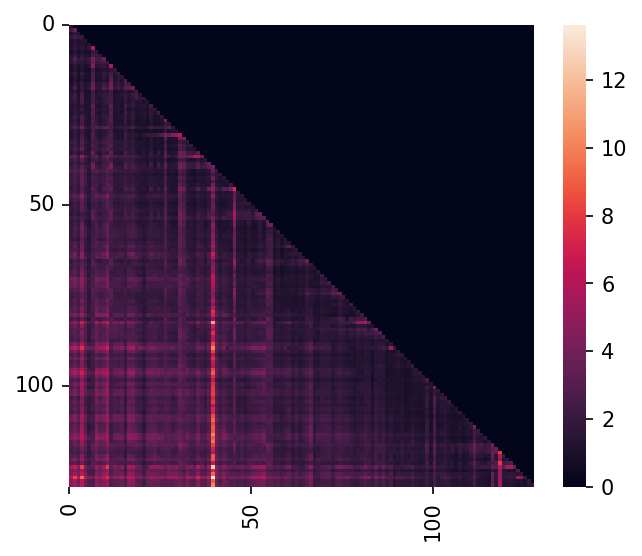

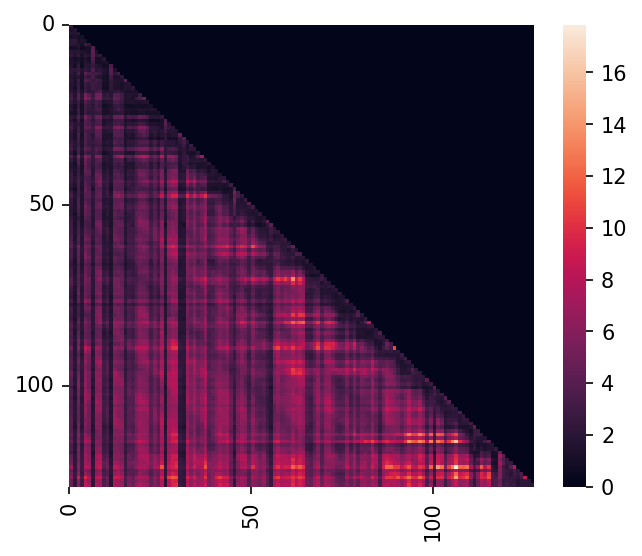

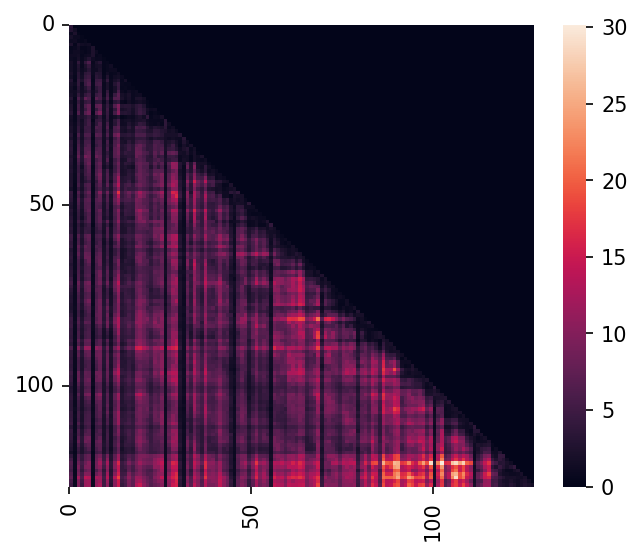

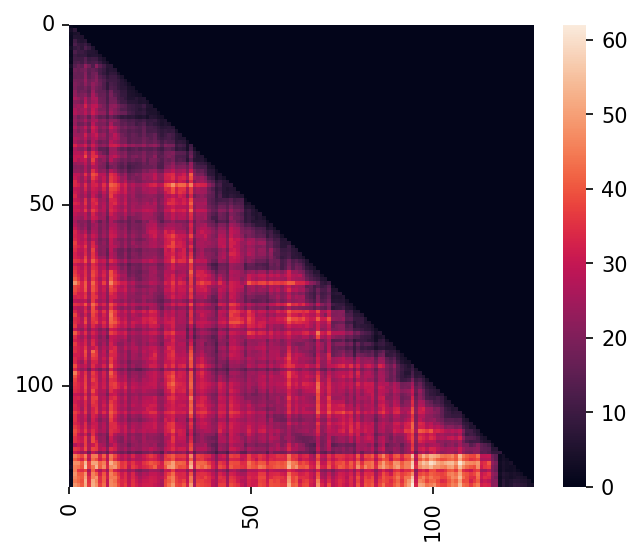

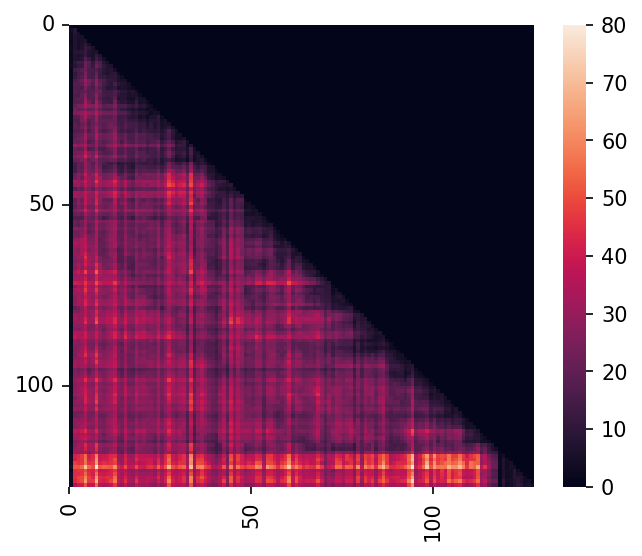

In [265]:
for l in range(0,5):
    fig, axes = plt.subplots(1, 1, figsize=(5, 4), dpi=150)
    fp_attn_layer = fp_attn[l]
    q_attn_layer = q_attn[l]
    
    fp_attn_layer = torch.where(fp_attn_layer <= -1e5, 0, fp_attn_layer)
    q_attn_layer = torch.where(q_attn_layer <= -1e5, 0, q_attn_layer)
    
    # Consider causal attention (upper-traiangular part masked)
    mask = torch.tril(torch.ones_like(fp_attn_layer.float())).bool()
    diff = fp_attn_layer - q_attn_layer
    
    diff[~mask] = 0
    map_diff = (diff ** 2).mean(dim=1).squeeze(0).cpu().detach().numpy()
    
    sns.heatmap(map_diff)
    # plt.title(f"{l} layer")
    plt.xticks(ticks=range(0, seq_len, 50), labels=range(0,seq_len, 50))
    plt.yticks(ticks=range(0, seq_len, 50), labels=range(0,seq_len, 50))
    plt.show()
    

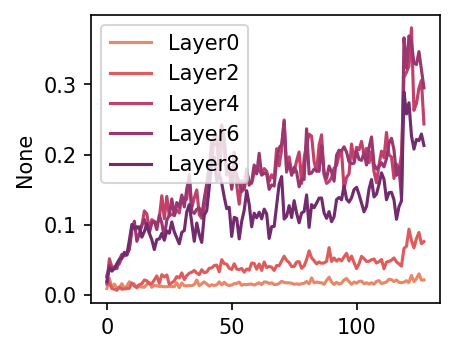

In [266]:
b = torch.arange(1, seq_len+1).float()
b = b.unsqueeze(1)

mse_none = MSELoss(reduction="none")
palette_1 = sns.color_palette("flare", 5)

fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
for i, l in enumerate(range(0,10,2)):
    fp_attn_layer = fp_attn[l]
    q_attn_layer = q_attn[l]

    # Consider causal attention (upper-traiangular part masked)
    mask = torch.tril(torch.ones_like(fp_attn_layer.float())).bool()
    
    fp_attn_layer[~mask] = 0
    q_attn_layer[~mask] = 0

    tc_score = fp_attn_layer.squeeze(0).detach().cpu()
    st_score = q_attn_layer.squeeze(0).detach().cpu()

    mse_all = mse_none(tc_score, st_score) / b
    per_token_mse = mse_all.mean(dim=[0,2])
    sns.lineplot(x=np.arange(seq_len), y=per_token_mse, color=palette_1[i], ax=axes, label=f"Layer{l}")
